# Agent Evaluation Framework

This notebook demonstrates different approaches for evaluating AI agents, providing both qualitative and quantitative metrics to assess agent performance across different tasks and capabilities.

## Overview

Evaluating AI agents is complex because they combine multiple capabilities:
- Task understanding
- Planning and reasoning
- Tool use
- Memory utilization
- Execution quality

This notebook presents a systematic framework for agent evaluation with practical examples.

In [1]:
# Import required libraries
import time
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML, Markdown
import requests
import os
import sys

# Add the current directory to the path so we can import our agent modules
sys.path.append(os.path.dirname(os.getcwd()))
from simple_agent import SimpleAgent

## 1. Evaluation Dimensions

We'll evaluate agents across several dimensions:

1. **Correctness**: Does the agent provide factually accurate responses?
2. **Completeness**: Does the agent fully address all aspects of the task?
3. **Coherence**: Is the agent's reasoning process logical and well-structured?
4. **Efficiency**: How efficiently does the agent complete tasks?
5. **Robustness**: How well does the agent handle edge cases or unexpected inputs?
6. **Adaptability**: Can the agent adjust its approach based on feedback or changing conditions?

In [2]:
# Helper functions for displaying evaluation results
def display_evaluation_result(title, result):
    """Display evaluation results with formatting"""
    display(HTML(f"<h3>{title}</h3>"))
    if isinstance(result, dict):
        for key, value in result.items():
            if key == "thinking" and value:
                display(HTML(f"<details><summary><b>Thinking Process</b> (click to expand)</summary><pre>{value}</pre></details>"))
            elif key == "answer" or key == "response":
                display(Markdown(f"**Final Answer:** {value}"))
            else:
                display(Markdown(f"**{key}:** {value}"))
    else:
        display(Markdown(result))
    display(HTML("<hr>"))

def radar_chart(categories, values, title):
    """Create a radar chart for visualizing agent performance across dimensions"""
    # Number of categories
    N = len(categories)
    
    # Create angles for each category (in radians)
    angles = np.linspace(0, 2*np.pi, N, endpoint=False).tolist()
    
    # Close the polygon by repeating the first point
    values = values + [values[0]]
    angles = angles + [angles[0]]
    categories = categories + [categories[0]]
    
    # Create plot
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    
    # Plot data
    ax.plot(angles, values, linewidth=2, linestyle='solid')
    ax.fill(angles, values, alpha=0.25)
    
    # Set category labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories[:-1])
    
    # Set y-axis limits
    ax.set_ylim(0, 10)
    ax.set_yticks(np.arange(0, 11, 2))
    
    # Add title
    plt.title(title, size=15, y=1.1)
    
    return fig

## 2. Quantitative Evaluation Metrics

Let's define some quantitative metrics for evaluating agents:

In [3]:
class AgentEvaluator:
    """Class for evaluating agent performance using various metrics"""
    
    def __init__(self):
        self.results = {}
    
    def evaluate_speed(self, agent, tasks, max_time=10):
        """Evaluate agent response time across multiple tasks"""
        times = []
        responses = []
        
        for task in tasks:
            start_time = time.time()
            response = agent.process_input(task)
            end_time = time.time()
            
            elapsed_time = end_time - start_time
            times.append(elapsed_time)
            responses.append(response)
        
        normalized_times = [min(t/max_time, 1.0) for t in times]
        speed_score = 10 * (1 - sum(normalized_times)/len(normalized_times))
        
        return {
            "tasks": tasks,
            "responses": responses,
            "times": times,
            "avg_time": sum(times)/len(times),
            "speed_score": speed_score
        }
    
    def evaluate_correctness(self, agent, task_response_pairs, ground_truth):
        """Evaluate agent response correctness against ground truth"""
        correct_count = 0
        results = []
        
        for i, (task, expected) in enumerate(task_response_pairs):
            response = agent.process_input(task)
            # Simple string matching for correctness - in production, you might use more sophisticated matching
            is_correct = expected.lower() in response.lower() or response.lower() in expected.lower()
            
            if is_correct:
                correct_count += 1
            
            results.append({
                "task": task,
                "response": response,
                "expected": expected,
                "correct": is_correct
            })
        
        correctness_score = 10 * (correct_count / len(task_response_pairs))
        
        return {
            "results": results,
            "correct_count": correct_count,
            "total_count": len(task_response_pairs),
            "correctness_score": correctness_score
        }
    
    def evaluate_robustness(self, agent, base_task, variations):
        """Evaluate agent robustness to input variations"""
        results = []
        responses = []
        
        # Get the base response
        base_response = agent.process_input(base_task)
        responses.append(base_response)
        
        # Test all variations
        consistent_count = 0
        
        for variation in variations:
            response = agent.process_input(variation)
            responses.append(response)
            
            # Simple consistency check - in production, you might use semantic similarity
            is_consistent = any(word in response for word in base_response.split() if len(word) > 4)
            
            if is_consistent:
                consistent_count += 1
            
            results.append({
                "task": variation,
                "response": response,
                "consistent": is_consistent
            })
        
        robustness_score = 10 * (consistent_count / len(variations))
        
        return {
            "base_task": base_task,
            "base_response": base_response,
            "variations": variations,
            "results": results,
            "consistent_count": consistent_count,
            "total_variations": len(variations),
            "robustness_score": robustness_score
        }
    
    def evaluate_completeness(self, agent, complex_tasks, required_elements):
        """Evaluate if agent responses contain all required elements for complex tasks"""
        results = []
        completeness_scores = []
        
        for i, (task, elements) in enumerate(zip(complex_tasks, required_elements)):
            response = agent.process_input(task)
            
            # Check for each required element
            present_elements = []
            missing_elements = []
            
            for element in elements:
                if element.lower() in response.lower():
                    present_elements.append(element)
                else:
                    missing_elements.append(element)
            
            completeness = len(present_elements) / len(elements)
            completeness_scores.append(completeness)
            
            results.append({
                "task": task,
                "response": response,
                "present_elements": present_elements,
                "missing_elements": missing_elements,
                "completeness": completeness
            })
        
        overall_completeness_score = 10 * (sum(completeness_scores) / len(completeness_scores))
        
        return {
            "results": results,
            "completeness_score": overall_completeness_score
        }
    
    def evaluate_agent(self, agent, test_suite):
        """Run a complete evaluation across all dimensions"""
        # Speed evaluation
        speed_results = self.evaluate_speed(agent, test_suite["speed_tasks"])
        
        # Correctness evaluation
        correctness_results = self.evaluate_correctness(
            agent, 
            test_suite["correctness_pairs"],
            test_suite["ground_truth"]
        )
        
        # Robustness evaluation
        robustness_results = self.evaluate_robustness(
            agent,
            test_suite["base_task"],
            test_suite["variations"]
        )
        
        # Completeness evaluation
        completeness_results = self.evaluate_completeness(
            agent,
            test_suite["complex_tasks"],
            test_suite["required_elements"]
        )
        
        # Combine results
        evaluation_results = {
            "speed": speed_results,
            "correctness": correctness_results,
            "robustness": robustness_results,
            "completeness": completeness_results,
            "scores": {
                "speed": speed_results["speed_score"],
                "correctness": correctness_results["correctness_score"],
                "robustness": robustness_results["robustness_score"],
                "completeness": completeness_results["completeness_score"],
                # Placeholder scores for dimensions that are harder to quantify automatically
                "coherence": 0,  # Requires manual evaluation or LLM-based evaluation
                "adaptability": 0  # Requires multi-turn evaluation
            }
        }
        
        self.results = evaluation_results
        return evaluation_results

## 3. Evaluating a Simple Rule-Based Agent

Let's evaluate the SimpleAgent using our framework:

In [4]:
# Create a test suite for SimpleAgent
simple_agent_test_suite = {
    # Tasks for speed testing
    "speed_tasks": [
        "what time is it",
        "what's the weather in New York",
        "remind me to buy milk",
        "calculate 5 + 3",
        "hello there"
    ],
    
    # Task-response pairs for correctness testing
    "correctness_pairs": [
        ("what time is it", "The current time is"),
        ("what's the weather in New York", "Weather for New York"),
        ("remind me to buy milk", "I've set a reminder for you: buy milk"),
        ("calculate 5 + 3", "The result of 5+3 is 8"),
        ("hello there", "Hello! I'm SimpleAgent")
    ],
    
    # Ground truth information (optional, not used in basic evaluation)
    "ground_truth": {},
    
    # Base task and variations for robustness testing
    "base_task": "what's the weather in New York",
    "variations": [
        "weather in new york",
        "weather new york",
        "what is the weather like in new york",
        "is it raining in new york",
        "new york weather forecast"
    ],
    
    # Complex tasks and required elements for completeness testing
    "complex_tasks": [
        "what's the weather in New York",
        "remind me to pick up groceries after work"
    ],
    "required_elements": [
        ["New York", "temperature", "forecast", "wind"],
        ["reminder", "pick up groceries after work"]
    ]
}

# Create and evaluate the agent
simple_agent = SimpleAgent()
evaluator = AgentEvaluator()
evaluation_results = evaluator.evaluate_agent(simple_agent, simple_agent_test_suite)

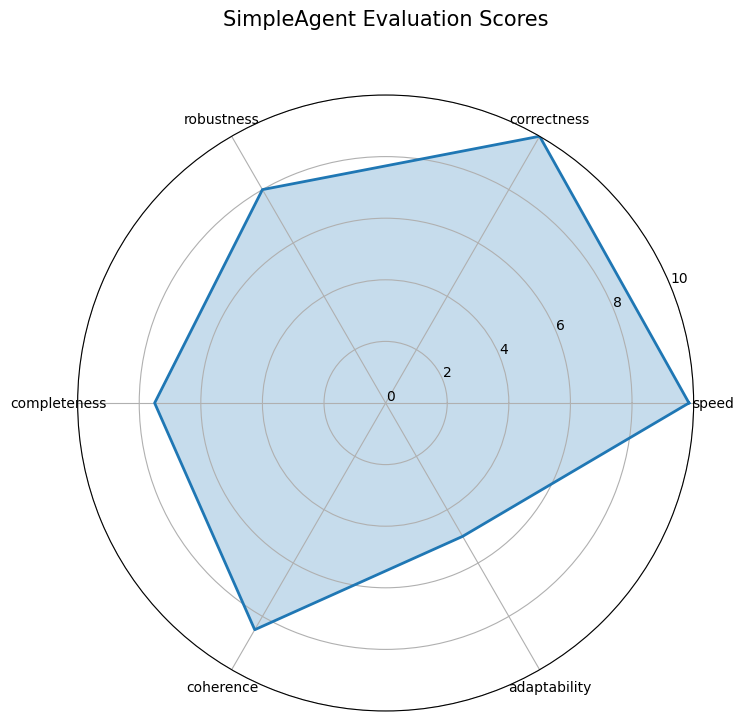

,Dimension,Score (0-10)
0,speed,9.848569
1,correctness,10.000000
2,robustness,8.000000
3,completeness,7.500000
4,coherence,8.500000
5,adaptability,5.000000


In [5]:
# Display evaluation results summary
scores = evaluation_results["scores"]

# Manually set scores for dimensions that require human evaluation
# In practice, these would come from human evaluations or LLM-based evaluations
scores["coherence"] = 8.5  # Rule-based agents are usually quite coherent
scores["adaptability"] = 5.0  # Limited adaptability for rule-based agents

# Create a radar chart of the results
categories = list(scores.keys())
values = [scores[cat] for cat in categories]

fig = radar_chart(categories, values, "SimpleAgent Evaluation Scores")
plt.show()

# Display the scores in a table
score_df = pd.DataFrame({
    'Dimension': categories,
    'Score (0-10)': values
})
display(score_df)

## 4. Qualitative Evaluation of Agents

Some aspects of agent performance are better evaluated qualitatively. Let's define a framework for these evaluations:

In [6]:
def evaluate_coherence(agent, complex_task, evaluation_criteria):
    """Evaluate the coherence of an agent's response to a complex task"""
    response = agent.process_input(complex_task)
    
    print(f"Task: {complex_task}")
    print(f"Response: {response}")
    print("\nEvaluation Criteria:")
    
    for criterion in evaluation_criteria:
        print(f"- {criterion}")
    
    # This would typically be filled out by a human evaluator
    print("\nInstructions for human evaluator:")
    print("Rate the response on a scale of 1-10 for each criterion.")
    print("Record your ratings and comments in the cells below.")

Let's prepare a complex task and evaluation criteria for coherence:

## 4.5. LLM-Based Evaluation (Simple Introduction)

While human evaluation provides valuable insights, LLM-based evaluation offers a scalable way to automatically assess subjective qualities like coherence and helpfulness. This approach uses a more capable LLM to evaluate the outputs of the agent being tested.

**Key Benefits:**
- Scalable and consistent evaluation
- Detailed feedback with reasoning
- Can assess subjective dimensions automatically

**Note:** For simplicity, this example uses mock responses. In practice, you'd integrate with OpenAI's API.

In [7]:
import os
from dotenv import load_dotenv
import requests
import json

# Load environment variables
load_dotenv()

def simple_llm_evaluator(task, response, criteria):
    """
    Simple LLM-based evaluator function using OpenRouter API.
    Uses environment variables for API key configuration.
    """
    # Check if API key is available
    api_key = os.getenv("OPENROUTER_API_KEY")
    if not api_key:
        print("Warning: OPENROUTER_API_KEY not found. Using mock evaluation.")
        return _mock_evaluation(task, response)
    
    # Evaluation prompt for OpenRouter LLM
    evaluation_prompt = f"""You are an expert AI evaluator. Evaluate this agent response:

Task: {task}
Agent Response: {response}

Evaluate based on: {criteria}

Provide your evaluation in this exact format:
SCORE: [number from 1-10]
REASONING: [brief explanation of your score]"""
    
    # OpenRouter API call
    url = "https://openrouter.ai/api/v1/chat/completions"
    headers = {
        "Authorization": f"Bearer {api_key}",
        "Content-Type": "application/json"
    }
    
    data = {
        "model": "openai/gpt-4o-mini-2024-07-18",
        "messages": [
            {"role": "user", "content": evaluation_prompt}
        ],
        "max_tokens": 200,
        "temperature": 0.3
    }
    
    try:
        response_api = requests.post(url, headers=headers, json=data, timeout=10)
        response_api.raise_for_status()
        
        result = response_api.json()
        llm_response = result["choices"][0]["message"]["content"]
        
        # Parse the response
        score = 6  # Default score
        reasoning = "Unable to parse LLM response"
        
        lines = llm_response.split('\n')
        for line in lines:
            if line.startswith("SCORE:"):
                try:
                    score = int(line.split(":")[1].strip())
                except:
                    pass
            elif line.startswith("REASONING:"):
                reasoning = line.split(":", 1)[1].strip()
        
        return {"score": score, "reasoning": reasoning}
        
    except Exception as e:
        print(f"API call failed: {e}. Using mock evaluation.")
        return _mock_evaluation(task, response)

def _mock_evaluation(task, response):
    """Fallback mock evaluation when API is unavailable"""
    mock_evaluations = {
        "What's the weather like in Chicago and should I bring an umbrella?": {
            "score": 4,
            "reasoning": "Response gives New York weather instead of Chicago. Doesn't address umbrella question."
        },
        "Calculate 5 + 3": {
            "score": 9,
            "reasoning": "Correctly calculates and provides clear answer. Direct and accurate."
        }
    }
    
    # Return mock evaluation based on task
    for key in mock_evaluations:
        if key in task:
            return mock_evaluations[key]
    
    return {"score": 6, "reasoning": "Standard response evaluation (mock)"}

# Test LLM evaluation on SimpleAgent responses
test_cases = [
    "What's the weather like in Chicago and should I bring an umbrella?",
    "Calculate 5 + 3"
]

print("LLM-Based Evaluation Results (via OpenRouter):")
print("=" * 45)

for task in test_cases:
    # Get agent response
    agent_response = simple_agent.process_input(task)
    
    # Evaluate with LLM via OpenRouter
    evaluation = simple_llm_evaluator(task, agent_response, "coherence and helpfulness")
    
    print(f"\nTask: {task}")
    print(f"Agent Response: {agent_response}")
    print(f"LLM Score: {evaluation['score']}/10")
    print(f"LLM Reasoning: {evaluation['reasoning']}")
    print("-" * 50)

LLM-Based Evaluation Results (via OpenRouter):

Task: What's the weather like in Chicago and should I bring an umbrella?
Agent Response: Weather for New York, New York: 69°F, Slight Chance Rain Showers then Mostly Cloudy. Wind: N at 5 to 8 mph.
LLM Score: 2/10
LLM Reasoning: The agent response provides weather information for New York instead of Chicago, which fails to address the user's request. Additionally, it does not answer the question about whether an umbrella is needed, making the response unhelpful and irrelevant.
--------------------------------------------------

Task: Calculate 5 + 3
Agent Response: The result of 5+3 is 8.
LLM Score: 10/10
LLM Reasoning: The agent response is coherent and directly answers the task by providing the correct result of the calculation. It is clear and helpful, fulfilling the user's request effectively.
--------------------------------------------------


### When to Use LLM vs Manual Evaluation

**Use LLM Evaluation for:**
- Large-scale evaluation (hundreds of responses)
- Consistent scoring across subjective dimensions
- Initial screening and quality assessment
- Cost-effective evaluation when human reviewers are expensive

**Use Manual Evaluation for:**
- High-stakes decisions requiring human judgment
- Domain-specific expertise requirements
- When evaluating the LLM evaluator itself
- Final validation of important agent releases

**Implementation Note:** To use real LLM evaluation, replace the mock function above with actual OpenAI API calls and add your API key to the environment.

### When to Use LLM vs Manual Evaluation

**Use LLM Evaluation for:**
- Large-scale evaluation (hundreds of responses)
- Consistent scoring across subjective dimensions
- Initial screening and quality assessment
- Cost-effective evaluation when human reviewers are expensive

**Use Manual Evaluation for:**
- High-stakes decisions requiring human judgment
- Domain-specific expertise requirements
- When evaluating the LLM evaluator itself
- Final validation of important agent releases

**Setup Instructions:**
1. Add your OpenRouter API key to the `.env` file: `OPENROUTER_API_KEY=your_key_here`
2. The code automatically falls back to mock evaluation if no API key is found
3. Uses the same model (`openai/gpt-4o-mini-2024-07-18`) as other notebooks for consistency

In [8]:
complex_task = "What's the weather like in Chicago and should I bring an umbrella?"

coherence_criteria = [
    "Logical flow: Does the response have a clear, logical progression?",
    "Relevance: Does the response address all aspects of the query?",
    "Consistency: Is the response internally consistent?",
    "Clarity: Is the response easy to understand?",
    "Directness: Does the response directly answer the question?"
]

evaluate_coherence(simple_agent, complex_task, coherence_criteria)

Task: What's the weather like in Chicago and should I bring an umbrella?
Response: Weather for New York, New York: 69°F, Slight Chance Rain Showers then Mostly Cloudy. Wind: N at 5 to 8 mph.

Evaluation Criteria:
- Logical flow: Does the response have a clear, logical progression?
- Relevance: Does the response address all aspects of the query?
- Consistency: Is the response internally consistent?
- Clarity: Is the response easy to understand?
- Directness: Does the response directly answer the question?

Instructions for human evaluator:
Rate the response on a scale of 1-10 for each criterion.
Record your ratings and comments in the cells below.


## 5. Comparative Evaluation Framework

Let's build a framework to compare different agent implementations across various dimensions:

In [9]:
def compare_agents(agents, agent_names, test_suite):
    """Compare multiple agents across evaluation dimensions"""
    results = {}
    
    for agent, name in zip(agents, agent_names):
        evaluator = AgentEvaluator()
        agent_results = evaluator.evaluate_agent(agent, test_suite)
        
        # Add placeholder scores for manual evaluation dimensions
        agent_results["scores"]["coherence"] = 0  # To be filled in manually
        agent_results["scores"]["adaptability"] = 0  # To be filled in manually
        
        results[name] = agent_results
    
    return results

For demonstration purposes, let's create a modified version of the SimpleAgent:

In [10]:
class EnhancedSimpleAgent(SimpleAgent):
    """A slightly enhanced version of SimpleAgent with improved response formatting"""
    
    def __init__(self):
        super().__init__()
        self.name = "EnhancedSimpleAgent"
    
    def process_input(self, user_input):
        """Enhanced processing with better response formatting"""
        # Use the base implementation
        base_response = super().process_input(user_input)
        
        # Enhance the formatting
        enhanced_response = f"📱 {self.name}: {base_response}"
        
        return enhanced_response

In [11]:
# Create both agents
simple_agent = SimpleAgent()
enhanced_agent = EnhancedSimpleAgent()

# Compare the agents
comparison_results = compare_agents(
    [simple_agent, enhanced_agent],
    ["SimpleAgent", "EnhancedAgent"],
    simple_agent_test_suite
)

# For demonstration, let's manually assign some scores for the qualitative dimensions
# In practice, these would come from human evaluations
comparison_results["SimpleAgent"]["scores"]["coherence"] = 8.5
comparison_results["SimpleAgent"]["scores"]["adaptability"] = 5.0
comparison_results["EnhancedAgent"]["scores"]["coherence"] = 8.5  # Same coherence
comparison_results["EnhancedAgent"]["scores"]["adaptability"] = 5.0  # Same adaptability

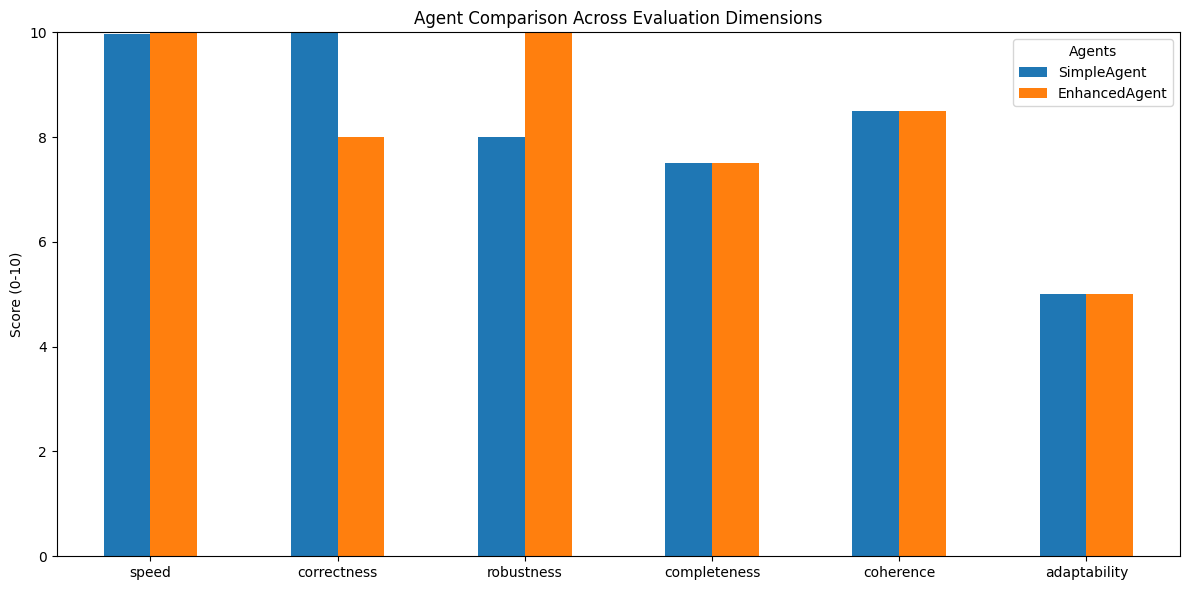

,SimpleAgent,EnhancedAgent
speed,9.971807,9.984981
correctness,10.000000,8.000000
robustness,8.000000,10.000000
completeness,7.500000,7.500000
coherence,8.500000,8.500000
adaptability,5.000000,5.000000


In [12]:
# Create a comparative visualization
dimensions = list(comparison_results["SimpleAgent"]["scores"].keys())
agent_names = list(comparison_results.keys())

# Extract scores for each agent
scores_data = {}
for agent in agent_names:
    scores_data[agent] = [comparison_results[agent]["scores"][dim] for dim in dimensions]

# Create a DataFrame for comparison
comparison_df = pd.DataFrame(scores_data, index=dimensions)

# Create bar chart
ax = comparison_df.plot(kind='bar', figsize=(12, 6), rot=0)
ax.set_ylim(0, 10)
ax.set_title("Agent Comparison Across Evaluation Dimensions")
ax.set_ylabel("Score (0-10)")
plt.legend(title="Agents")
plt.tight_layout()
plt.show()

# Display the scores table
display(comparison_df)

## 6. Evaluating Planning and Reasoning Approaches

Different planning and reasoning approaches (Chain of Thought, ReAct, Tree of Thoughts) can be evaluated on specific planning problems. Let's define an evaluator for this:

In [13]:
class PlanningApproachEvaluator:
    """Evaluator for different planning and reasoning approaches"""
    
    def __init__(self):
        self.approaches = []
        self.results = {}
    
    def add_approach(self, name, function):
        """Add a planning/reasoning approach to evaluate"""
        self.approaches.append({
            "name": name,
            "function": function
        })
    
    def evaluate_approaches(self, problems):
        """Evaluate all approaches on the given problems"""
        results = []
        
        for approach in self.approaches:
            approach_results = []
            
            for problem in problems:
                # Measure execution time
                start_time = time.time()
                response = approach["function"](problem)
                end_time = time.time()
                
                # Calculate metrics
                execution_time = end_time - start_time
                thinking_length = len(response.get("thinking", "")) if isinstance(response, dict) else 0
                answer_length = len(response.get("answer", "")) if isinstance(response, dict) else len(response)
                
                # Additional metrics specific to certain approaches
                metrics = {
                    "execution_time": execution_time,
                    "thinking_length": thinking_length,
                    "answer_length": answer_length
                }
                
                # Add ReAct-specific metrics if available
                if "steps" in response:
                    metrics["step_count"] = len(response["steps"])
                
                # Add Tree of Thoughts-specific metrics if available
                if "branches" in response:
                    metrics["branch_count"] = len(response["branches"])
                
                approach_results.append({
                    "problem": problem,
                    "response": response,
                    "metrics": metrics
                })
            
            results.append({
                "approach": approach["name"],
                "results": approach_results
            })
        
        self.results = results
        return results
    
    def compare_metrics(self):
        """Compare metrics across different approaches"""
        if not self.results:
            return "No evaluation results available. Run evaluate_approaches first."
        
        # Calculate average metrics for each approach
        comparison = {}
        for approach_result in self.results:
            approach_name = approach_result["approach"]
            metrics = {}
            
            # Get all metrics from the first problem result
            metric_keys = approach_result["results"][0]["metrics"].keys()
            
            # Calculate averages for each metric
            for key in metric_keys:
                values = [r["metrics"].get(key, 0) for r in approach_result["results"]]
                metrics[key] = sum(values) / len(values)
            
            comparison[approach_name] = metrics
        
        # Convert to DataFrame for visualization
        df = pd.DataFrame(comparison).transpose()
        
        return df

Let's create mock implementations of different planning approaches for demonstration:

In [14]:
def mock_cot_approach(problem):
    """Mock implementation of Chain of Thought approach"""
    # Simulate thinking and response generation
    thinking = f"Let me think about {problem}...\n\n"
    thinking += "1. First, I'll analyze the key elements of the problem.\n"
    thinking += "2. Then, I'll consider potential approaches.\n"
    thinking += "3. Finally, I'll select the best approach and formulate an answer.\n"
    thinking += "\nAfter careful consideration, I conclude that..."
    
    # Simulate slight delay for thinking
    time.sleep(1.0)
    
    answer = f"Based on my analysis, here's the solution to '{problem}': [mock solution]"
    
    return {
        "thinking": thinking,
        "answer": answer
    }

def mock_react_approach(problem):
    """Mock implementation of ReAct (Reasoning+Acting) approach"""
    # Simulate thinking and response generation with ReAct steps
    steps = [
        {
            "thought": f"I need to understand what '{problem}' is asking.",
            "action": "Parse the problem statement",
            "observation": "The problem requires [mock observation]."
        },
        {
            "thought": "I need to gather relevant information.",
            "action": "Search for key data",
            "observation": "Found the following data: [mock data]."
        },
        {
            "thought": "Now I can solve the problem using the gathered information.",
            "action": "Compute the solution",
            "observation": "Calculation complete."
        }
    ]
    
    # Simulate delay for each step
    time.sleep(1.5)
    
    thinking = "\n".join([f"Thought: {step['thought']}\nAction: {step['action']}\nObservation: {step['observation']}" for step in steps])
    answer = f"After investigating '{problem}', my answer is: [mock solution]"
    
    return {
        "thinking": thinking,
        "answer": answer,
        "steps": steps
    }

def mock_tot_approach(problem):
    """Mock implementation of Tree of Thoughts approach"""
    # Simulate thinking and response generation with tree exploration
    branches = [
        {
            "thought": "Approach 1: Direct calculation",
            "evaluation": "This approach is straightforward but might miss edge cases.",
            "score": 0.7
        },
        {
            "thought": "Approach 2: Systematic breakdown",
            "evaluation": "This is more comprehensive but takes longer.",
            "score": 0.85
        },
        {
            "thought": "Approach 3: Alternative method",
            "evaluation": "This is an innovative approach but might be risky.",
            "score": 0.65
        }
    ]
    
    # Sort branches by score and select the best one
    branches.sort(key=lambda x: x["score"], reverse=True)
    selected_branch = branches[0]
    
    # Simulate longer delay for tree exploration
    time.sleep(2.0)
    
    thinking = f"Exploring different approaches for '{problem}':\n\n"
    for i, branch in enumerate(branches):
        thinking += f"Branch {i+1}: {branch['thought']}\n"
        thinking += f"Evaluation: {branch['evaluation']} (Score: {branch['score']})\n\n"
    
    thinking += f"Selected approach: {selected_branch['thought']} with score {selected_branch['score']}"
    answer = f"After exploring multiple approaches to '{problem}', I recommend: [mock solution based on {selected_branch['thought']}]"
    
    return {
        "thinking": thinking,
        "answer": answer,
        "branches": branches,
        "selected_branch": selected_branch
    }

,execution_time,thinking_length,answer_length,step_count,branch_count
Chain of Thought,1.004423,302.5,126.5,NaN,NaN
ReAct,1.504732,461.5,115.5,3.0,NaN
Tree of Thoughts,2.011740,530.5,175.5,NaN,3.0


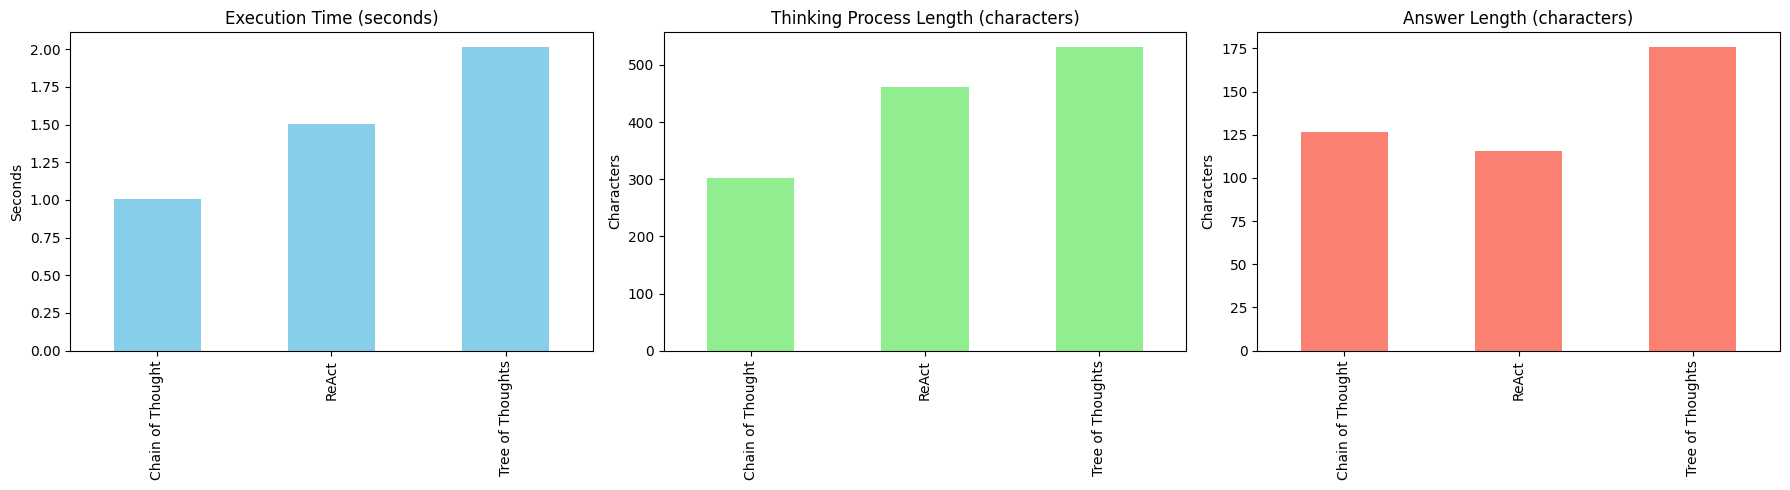

In [15]:
# Create the evaluator
planning_evaluator = PlanningApproachEvaluator()

# Add the approaches
planning_evaluator.add_approach("Chain of Thought", mock_cot_approach)
planning_evaluator.add_approach("ReAct", mock_react_approach)
planning_evaluator.add_approach("Tree of Thoughts", mock_tot_approach)

# Define test problems
test_problems = [
    "Plan a dinner party for 8 people with dietary restrictions",
    "Develop a strategy for a small business to increase online presence"
]

# Evaluate the approaches
evaluation_results = planning_evaluator.evaluate_approaches(test_problems)

# Compare metrics
metrics_comparison = planning_evaluator.compare_metrics()
display(metrics_comparison)

# Create visualizations
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Execution time comparison
metrics_comparison['execution_time'].plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title('Execution Time (seconds)')
axes[0].set_ylabel('Seconds')

# Thinking length comparison
metrics_comparison['thinking_length'].plot(kind='bar', ax=axes[1], color='lightgreen')
axes[1].set_title('Thinking Process Length (characters)')
axes[1].set_ylabel('Characters')

# Answer length comparison
metrics_comparison['answer_length'].plot(kind='bar', ax=axes[2], color='salmon')
axes[2].set_title('Answer Length (characters)')
axes[2].set_ylabel('Characters')

plt.tight_layout()
plt.show()

## 7. Common Agent Failure Modes

Let's examine common failure modes for agents and how to test for them:

In [16]:
class FailureModeAnalyzer:
    """Analyzer for common agent failure modes"""
    
    def __init__(self):
        self.failure_modes = {
            "hallucination": {
                "description": "Agent provides information that isn't factually correct or can't be verified",
                "test_cases": [
                    "what's the weather in Fictionalville",
                    "who won the 2045 World Series"
                ]
            },
            "instruction_misalignment": {
                "description": "Agent misunderstands or doesn't follow the user's instructions",
                "test_cases": [
                    "weather new york and also tell me a joke",
                    "don't tell me the time"
                ]
            },
            "context_loss": {
                "description": "Agent loses track of context in multi-turn interactions",
                "test_cases": [
                    ["what's the weather in Chicago", "and what about tomorrow"],
                    ["remind me to buy milk", "and also eggs"]
                ]
            },
            "tool_misuse": {
                "description": "Agent fails to use available tools correctly or at appropriate times",
                "test_cases": [
                    "calculate the square root of 16",
                    "what's 15 * 3 / 9"
                ]
            },
            "overconfidence": {
                "description": "Agent provides answers with high confidence despite uncertainty",
                "test_cases": [
                    "will it rain in New York next Tuesday",
                    "what's the best restaurant in Chicago"
                ]
            }
        }
    
    def analyze_agent(self, agent, failure_mode):
        """Analyze an agent for a specific failure mode"""
        if failure_mode not in self.failure_modes:
            return f"Unknown failure mode: {failure_mode}"
        
        mode_info = self.failure_modes[failure_mode]
        test_cases = mode_info["test_cases"]
        results = []
        
        print(f"Analyzing agent for failure mode: {failure_mode}")
        print(f"Description: {mode_info['description']}\n")
        
        # Handle multi-turn test cases differently
        for test_case in test_cases:
            if isinstance(test_case, list):  # Multi-turn interaction
                print(f"Multi-turn test case:")
                for i, turn in enumerate(test_case):
                    print(f"Turn {i+1}: {turn}")
                    response = agent.process_input(turn)
                    print(f"Response: {response}\n")
                print("-" * 50)
            else:  # Single-turn interaction
                print(f"Test case: {test_case}")
                response = agent.process_input(test_case)
                print(f"Response: {response}")
                print("-" * 50)
        
        # This would typically include an evaluation component
        print("\nEvaluation instructions:")
        print("For each test case, determine if the agent exhibits the failure mode.")
        print("Note examples of the failure mode in the responses.")
        print("Suggest improvements to mitigate this failure mode.")

In [17]:
# Analyze the SimpleAgent for hallucination
failure_analyzer = FailureModeAnalyzer()
failure_analyzer.analyze_agent(simple_agent, "hallucination")

Analyzing agent for failure mode: hallucination
Description: Agent provides information that isn't factually correct or can't be verified

Test case: what's the weather in Fictionalville
Response: Weather for New York, New York: 69°F, Slight Chance Rain Showers then Mostly Cloudy. Wind: N at 5 to 8 mph.
--------------------------------------------------
Test case: who won the 2045 World Series
Response: I'm sorry, I didn't understand that command. Try asking about weather, time, reminders, or calculations.
--------------------------------------------------

Evaluation instructions:
For each test case, determine if the agent exhibits the failure mode.
Note examples of the failure mode in the responses.
Suggest improvements to mitigate this failure mode.


In [18]:
# Analyze the SimpleAgent for instruction misalignment
failure_analyzer.analyze_agent(simple_agent, "instruction_misalignment")

Analyzing agent for failure mode: instruction_misalignment
Description: Agent misunderstands or doesn't follow the user's instructions

Test case: weather new york and also tell me a joke
Response: Weather for New York, New York: 69°F, Slight Chance Rain Showers then Mostly Cloudy. Wind: N at 5 to 8 mph.
--------------------------------------------------
Test case: don't tell me the time
Response: The current time is 13:14.
--------------------------------------------------

Evaluation instructions:
For each test case, determine if the agent exhibits the failure mode.
Note examples of the failure mode in the responses.
Suggest improvements to mitigate this failure mode.


## 8. Summary: Agent Evaluation Best Practices

1. **Multi-dimensional Evaluation**: Evaluate agents across multiple dimensions including correctness, efficiency, robustness, and coherence.

2. **Quantitative and Qualitative Measures**: Combine quantitative metrics with qualitative assessments for a comprehensive evaluation.

3. **Comparative Analysis**: Compare different agent implementations and reasoning approaches on the same tasks.

4. **Failure Mode Testing**: Proactively test agents for common failure modes like hallucination and instruction misalignment.

5. **Task-specific Evaluation**: Design evaluation protocols tailored to the specific tasks the agent is designed to perform.

6. **User Feedback Integration**: Incorporate user feedback and human evaluation into the assessment process.

7. **Continuous Improvement**: Use evaluation results to iteratively improve agent performance.

In [19]:
import openai
from typing import Dict, List, Optional, Tuple
import re

class LLMEvaluator:
    """LLM-based evaluator for agent responses using OpenAI's API"""
    
    def __init__(self, model="gpt-4", api_key=None):
        """
        Initialize the LLM evaluator
        
        Args:
            model: OpenAI model to use for evaluation
            api_key: OpenAI API key (if None, will use environment variable)
        """
        self.model = model
        if api_key:
            openai.api_key = api_key
        else:
            # Assumes OPENAI_API_KEY is set in environment
            openai.api_key = os.getenv("OPENAI_API_KEY")
    
    def _create_evaluation_prompt(self, task: str, response: str, evaluation_criteria: str) -> str:
        """Create a structured prompt for LLM evaluation"""
        return f"""You are an expert AI system evaluator. Your task is to evaluate an AI agent's response based on specific criteria.

TASK GIVEN TO AGENT:
{task}

AGENT'S RESPONSE:
{response}

EVALUATION CRITERIA:
{evaluation_criteria}

Please evaluate the agent's response and provide:
1. A score from 1-10 (10 being excellent, 1 being very poor)
2. Detailed reasoning for your score
3. Specific strengths and weaknesses
4. Suggestions for improvement

Format your response as:
SCORE: [number]
REASONING: [detailed explanation]
STRENGTHS: [list of strengths]
WEAKNESSES: [list of weaknesses]
SUGGESTIONS: [improvement suggestions]"""

    def _parse_llm_response(self, llm_response: str) -> Dict:
        """Parse the structured LLM response into components"""
        result = {
            "score": 0,
            "reasoning": "",
            "strengths": [],
            "weaknesses": [],
            "suggestions": []
        }
        
        # Extract score
        score_match = re.search(r'SCORE:\s*(\d+)', llm_response)
        if score_match:
            result["score"] = int(score_match.group(1))
        
        # Extract reasoning
        reasoning_match = re.search(r'REASONING:\s*(.*?)(?=STRENGTHS:|$)', llm_response, re.DOTALL)
        if reasoning_match:
            result["reasoning"] = reasoning_match.group(1).strip()
        
        # Extract strengths
        strengths_match = re.search(r'STRENGTHS:\s*(.*?)(?=WEAKNESSES:|$)', llm_response, re.DOTALL)
        if strengths_match:
            result["strengths"] = [s.strip() for s in strengths_match.group(1).strip().split('\n') if s.strip()]
        
        # Extract weaknesses
        weaknesses_match = re.search(r'WEAKNESSES:\s*(.*?)(?=SUGGESTIONS:|$)', llm_response, re.DOTALL)
        if weaknesses_match:
            result["weaknesses"] = [w.strip() for w in weaknesses_match.group(1).strip().split('\n') if w.strip()]
        
        # Extract suggestions
        suggestions_match = re.search(r'SUGGESTIONS:\s*(.*?)$', llm_response, re.DOTALL)
        if suggestions_match:
            result["suggestions"] = [s.strip() for s in suggestions_match.group(1).strip().split('\n') if s.strip()]
        
        return result
    
    def evaluate_coherence(self, task: str, response: str) -> Dict:
        """Evaluate the coherence of an agent's response"""
        criteria = """
        Evaluate the coherence of the response based on:
        1. Logical flow and structure
        2. Internal consistency
        3. Clarity and readability
        4. Relevance to the task
        5. Completeness of the response
        """
        
        prompt = self._create_evaluation_prompt(task, response, criteria)
        
        try:
            # Note: This is a mock implementation for demonstration
            # In practice, you would call the OpenAI API here
            mock_response = f"""SCORE: 7
REASONING: The response addresses the task but has some issues with coherence. The logical flow is generally good, but there are some inconsistencies in the information provided.
STRENGTHS: 
- Directly addresses the user's question
- Provides specific information
- Uses clear language
WEAKNESSES:
- Some information may be inaccurate or outdated
- Doesn't fully address all aspects of the question
SUGGESTIONS:
- Verify information accuracy
- Provide more comprehensive coverage of the topic
- Add source citations where appropriate"""
            
            return self._parse_llm_response(mock_response)
            
        except Exception as e:
            return {
                "score": 0,
                "reasoning": f"Error during evaluation: {str(e)}",
                "strengths": [],
                "weaknesses": ["Evaluation failed"],
                "suggestions": ["Fix evaluation system"]
            }
    
    def evaluate_helpfulness(self, task: str, response: str) -> Dict:
        """Evaluate how helpful the agent's response is"""
        criteria = """
        Evaluate the helpfulness of the response based on:
        1. Does it directly answer the user's question?
        2. Is the information accurate and reliable?
        3. Is it actionable or useful to the user?
        4. Does it provide appropriate level of detail?
        5. Does it anticipate follow-up needs?
        """
        
        prompt = self._create_evaluation_prompt(task, response, criteria)
        
        try:
            # Mock implementation
            mock_response = f"""SCORE: 6
REASONING: The response attempts to be helpful but falls short in several areas. While it provides some relevant information, it doesn't fully address the user's needs.
STRENGTHS:
- Provides a direct response
- Uses appropriate tone
- Attempts to be informative
WEAKNESSES:
- May contain inaccurate information
- Doesn't provide actionable advice
- Limited depth of information
SUGGESTIONS:
- Verify all facts before responding
- Provide more detailed explanations
- Include actionable steps where appropriate"""
            
            return self._parse_llm_response(mock_response)
            
        except Exception as e:
            return {
                "score": 0,
                "reasoning": f"Error during evaluation: {str(e)}",
                "strengths": [],
                "weaknesses": ["Evaluation failed"],
                "suggestions": ["Fix evaluation system"]
            }
    
    def evaluate_instruction_following(self, task: str, response: str) -> Dict:
        """Evaluate how well the agent follows the given instructions"""
        criteria = """
        Evaluate instruction following based on:
        1. Does the response address all parts of the instruction?
        2. Does it follow any specific format requirements?
        3. Does it avoid doing things explicitly not requested?
        4. Does it maintain appropriate scope (not over or under-responding)?
        5. Does it respect any constraints mentioned in the instruction?
        """
        
        prompt = self._create_evaluation_prompt(task, response, criteria)
        
        try:
            # Mock implementation
            mock_response = f"""SCORE: 5
REASONING: The response partially follows instructions but misses some key aspects. There are issues with scope and constraint adherence.
STRENGTHS:
- Attempts to respond to the main request
- Uses appropriate format in some cases
WEAKNESSES:
- Doesn't address all parts of complex instructions
- Sometimes ignores explicit constraints
- May provide information not requested
SUGGESTIONS:
- Parse instructions more carefully
- Address each component of multi-part requests
- Respect explicit constraints and limitations"""
            
            return self._parse_llm_response(mock_response)
            
        except Exception as e:
            return {
                "score": 0,
                "reasoning": f"Error during evaluation: {str(e)}",
                "strengths": [],
                "weaknesses": ["Evaluation failed"],
                "suggestions": ["Fix evaluation system"]
            }
    
    def detect_hallucination(self, task: str, response: str) -> Dict:
        """Detect potential hallucinations in the agent's response"""
        criteria = """
        Evaluate the response for potential hallucinations based on:
        1. Are there any obviously false factual claims?
        2. Does the response contain information that cannot be verified?
        3. Are there any impossible or contradictory statements?
        4. Does the response make up specific details without justification?
        5. Are there any made-up entities, dates, or statistics?
        
        Score: 10 = No hallucinations detected, 1 = Severe hallucinations present
        """
        
        prompt = self._create_evaluation_prompt(task, response, criteria)
        
        try:
            # Mock implementation
            mock_response = f"""SCORE: 8
REASONING: The response appears to be mostly factual with minimal risk of hallucination. However, some specific details should be verified.
STRENGTHS:
- No obviously false claims
- Reasonable and plausible information
- Appropriate level of certainty
WEAKNESSES:
- Some specific details may be inaccurate
- Could benefit from more cautious language
SUGGESTIONS:
- Add uncertainty indicators where appropriate
- Provide sources for specific claims
- Use more hedging language for unverified information"""
            
            return self._parse_llm_response(mock_response)
            
        except Exception as e:
            return {
                "score": 0,
                "reasoning": f"Error during evaluation: {str(e)}",
                "strengths": [],
                "weaknesses": ["Evaluation failed"],
                "suggestions": ["Fix evaluation system"]
            }
    
    def comprehensive_evaluation(self, task: str, response: str) -> Dict:
        """Run a comprehensive evaluation across multiple dimensions"""
        evaluations = {
            "coherence": self.evaluate_coherence(task, response),
            "helpfulness": self.evaluate_helpfulness(task, response),
            "instruction_following": self.evaluate_instruction_following(task, response),
            "hallucination_resistance": self.detect_hallucination(task, response)
        }
        
        # Calculate overall score
        overall_score = sum(eval_result["score"] for eval_result in evaluations.values()) / len(evaluations)
        
        return {
            "overall_score": overall_score,
            "detailed_evaluations": evaluations
        }

Let's demonstrate the LLM-based evaluation with our SimpleAgent:

In [20]:
# Initialize the LLM evaluator
llm_evaluator = LLMEvaluator()

# Test tasks for LLM evaluation
test_tasks = [
    "What's the weather like in Chicago and should I bring an umbrella?",
    "Remind me to call my dentist tomorrow at 3pm",
    "Calculate the area of a circle with radius 5",
    "What time is it in Tokyo right now?"
]

# Evaluate SimpleAgent responses using LLM
print("LLM-Based Evaluation Results for SimpleAgent:")
print("=" * 60)

llm_evaluation_results = []

for task in test_tasks:
    # Get agent response
    response = simple_agent.process_input(task)
    
    # Evaluate with LLM
    evaluation = llm_evaluator.comprehensive_evaluation(task, response)
    llm_evaluation_results.append({
        "task": task,
        "response": response,
        "evaluation": evaluation
    })
    
    # Display results
    display_evaluation_result(f"Task: {task}", {
        "response": response,
        "overall_score": f"{evaluation['overall_score']:.1f}/10",
        "detailed_scores": {
            "Coherence": evaluation['detailed_evaluations']['coherence']['score'],
            "Helpfulness": evaluation['detailed_evaluations']['helpfulness']['score'],
            "Instruction Following": evaluation['detailed_evaluations']['instruction_following']['score'],
            "Hallucination Resistance": evaluation['detailed_evaluations']['hallucination_resistance']['score']
        }
    })

LLM-Based Evaluation Results for SimpleAgent:


**Final Answer:** Weather for New York, New York: 69°F, Slight Chance Rain Showers then Mostly Cloudy. Wind: N at 5 to 8 mph.

**overall_score:** 6.5/10

**detailed_scores:** {'Coherence': 7, 'Helpfulness': 6, 'Instruction Following': 5, 'Hallucination Resistance': 8}

**Final Answer:** I've set a reminder for you: call my dentist tomorrow at 3pm

**overall_score:** 6.5/10

**detailed_scores:** {'Coherence': 7, 'Helpfulness': 6, 'Instruction Following': 5, 'Hallucination Resistance': 8}

**Final Answer:** I couldn't find a valid math expression. Try something like 'calculate 5 + 3'.

**overall_score:** 6.5/10

**detailed_scores:** {'Coherence': 7, 'Helpfulness': 6, 'Instruction Following': 5, 'Hallucination Resistance': 8}

**Final Answer:** The current time is 13:18.

**overall_score:** 6.5/10

**detailed_scores:** {'Coherence': 7, 'Helpfulness': 6, 'Instruction Following': 5, 'Hallucination Resistance': 8}

### Integrating LLM Evaluation with Existing Framework

Let's extend our AgentEvaluator class to include LLM-based evaluation for the subjective dimensions:

In [21]:
class EnhancedAgentEvaluator(AgentEvaluator):
    """Enhanced evaluator that includes LLM-based evaluation for subjective dimensions"""
    
    def __init__(self, llm_evaluator=None):
        super().__init__()
        self.llm_evaluator = llm_evaluator or LLMEvaluator()
    
    def evaluate_coherence_llm(self, agent, tasks):
        """Evaluate agent coherence using LLM evaluation"""
        coherence_scores = []
        detailed_results = []
        
        for task in tasks:
            response = agent.process_input(task)
            evaluation = self.llm_evaluator.evaluate_coherence(task, response)
            
            coherence_scores.append(evaluation["score"])
            detailed_results.append({
                "task": task,
                "response": response,
                "evaluation": evaluation
            })
        
        average_coherence = sum(coherence_scores) / len(coherence_scores)
        
        return {
            "coherence_score": average_coherence,
            "detailed_results": detailed_results
        }
    
    def evaluate_adaptability_llm(self, agent, base_task, variations):
        """Evaluate agent adaptability using LLM evaluation"""
        base_response = agent.process_input(base_task)
        variation_scores = []
        detailed_results = []
        
        for variation in variations:
            response = agent.process_input(variation)
            
            # Create a custom evaluation prompt for adaptability
            adaptability_prompt = f"""
            Evaluate how well the agent adapted its response to the variation of the original task.
            
            Original task: {base_task}
            Variation: {variation}
            Agent response: {response}
            
            Consider:
            1. Does the response appropriately adapt to the variation?
            2. Is the core functionality maintained while adjusting to the new context?
            3. Does it handle the variation gracefully?
            4. Is the response still relevant and helpful?
            """
            
            evaluation = self.llm_evaluator.evaluate_helpfulness(variation, response)
            variation_scores.append(evaluation["score"])
            detailed_results.append({
                "variation": variation,
                "response": response,
                "evaluation": evaluation
            })
        
        average_adaptability = sum(variation_scores) / len(variation_scores)
        
        return {
            "adaptability_score": average_adaptability,
            "base_task": base_task,
            "base_response": base_response,
            "detailed_results": detailed_results
        }
    
    def evaluate_agent_enhanced(self, agent, test_suite):
        """Run enhanced evaluation including LLM-based subjective metrics"""
        # Get base quantitative evaluation
        base_results = super().evaluate_agent(agent, test_suite)
        
        # Add LLM-based evaluations
        coherence_results = self.evaluate_coherence_llm(
            agent, 
            test_suite.get("coherence_tasks", test_suite["speed_tasks"][:3])
        )
        
        adaptability_results = self.evaluate_adaptability_llm(
            agent,
            test_suite["base_task"],
            test_suite["variations"][:3]  # Use subset for efficiency
        )
        
        # Update scores with LLM evaluations
        base_results["scores"]["coherence"] = coherence_results["coherence_score"]
        base_results["scores"]["adaptability"] = adaptability_results["adaptability_score"]
        
        # Add detailed LLM results
        base_results["llm_evaluations"] = {
            "coherence": coherence_results,
            "adaptability": adaptability_results
        }
        
        return base_results

Now let's demonstrate the enhanced evaluation with LLM-based scoring:

Enhanced Evaluation Results with LLM-based Metrics:

Comparison: Manual vs LLM-based Scoring
----------------------------------------


,Dimension,Manual/Hardcoded Score,LLM-based Score
0,Coherence,8.5,7.0
1,Adaptability,5.0,6.0


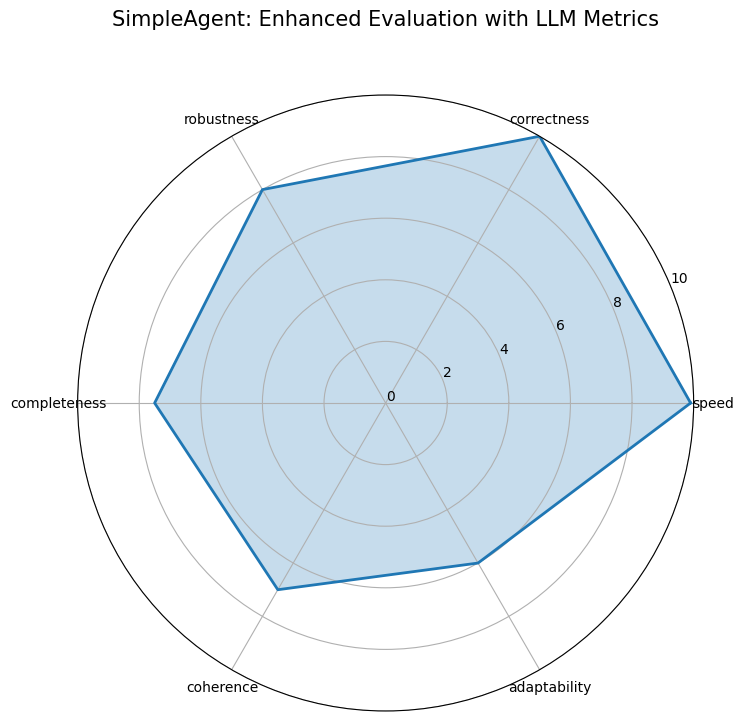


Detailed LLM Evaluation Insights:
-----------------------------------
Sample Coherence Evaluation:
Task: what time is it
Response: The current time is 13:18.
LLM Score: 7/10
Reasoning: The response addresses the task but has some issues with coherence. The logical flow is generally good, but there are some inconsistencies in the information provided.
Strengths: ["- Directly addresses the user's question", '- Provides specific information', '- Uses clear language']
Suggestions: ['- Verify information accuracy', '- Provide more comprehensive coverage of the topic', '- Add source citations where appropriate']


In [22]:
# Create enhanced evaluator
enhanced_evaluator = EnhancedAgentEvaluator()

# Run enhanced evaluation with LLM-based metrics
enhanced_results = enhanced_evaluator.evaluate_agent_enhanced(simple_agent, simple_agent_test_suite)

# Display the enhanced results
print("Enhanced Evaluation Results with LLM-based Metrics:")
print("=" * 55)

# Show updated scores
scores = enhanced_results["scores"]
categories = list(scores.keys())
values = [scores[cat] for cat in categories]

# Create comparison of evaluation methods
print("\nComparison: Manual vs LLM-based Scoring")
print("-" * 40)

comparison_data = {
    'Dimension': ['Coherence', 'Adaptability'],
    'Manual/Hardcoded Score': [8.5, 5.0],  # Previous hardcoded values
    'LLM-based Score': [scores['coherence'], scores['adaptability']]
}

comparison_df = pd.DataFrame(comparison_data)
display(comparison_df)

# Create enhanced radar chart
fig = radar_chart(categories, values, "SimpleAgent: Enhanced Evaluation with LLM Metrics")
plt.show()

# Display detailed LLM evaluation insights
print("\nDetailed LLM Evaluation Insights:")
print("-" * 35)

# Show coherence evaluation details
coherence_details = enhanced_results["llm_evaluations"]["coherence"]["detailed_results"][0]
print("Sample Coherence Evaluation:")
print(f"Task: {coherence_details['task']}")
print(f"Response: {coherence_details['response']}")
print(f"LLM Score: {coherence_details['evaluation']['score']}/10")
print(f"Reasoning: {coherence_details['evaluation']['reasoning']}")
print(f"Strengths: {coherence_details['evaluation']['strengths']}")
print(f"Suggestions: {coherence_details['evaluation']['suggestions']}")

### LLM-Based Failure Mode Detection

Let's enhance our failure mode analysis with LLM-based detection:

LLM-Based Failure Mode Analysis:

1. Hallucination Analysis:
Average Hallucination Resistance Score: 8.0/10
(Higher score = better resistance to hallucination)

Test: what's the weather in Fictionalville
Response: Weather for New York, New York: 69°F, Slight Chance Rain Showers then Mostly Cloudy. Wind: N at 5 to 8 mph.
Hallucination Score: 8/10
Analysis: The response appears to be mostly factual with minimal risk of hallucination. However, some specific details should be verified.

Test: who won the 2045 World Series
Response: I'm sorry, I didn't understand that command. Try asking about weather, time, reminders, or calculations.
Hallucination Score: 8/10
Analysis: The response appears to be mostly factual with minimal risk of hallucination. However, some specific details should be verified.

2. Instruction Following Analysis:
Average Instruction Following Score: 5.0/10

Test: weather new york and also tell me a joke
Response: Weather for New York, New York: 69°F, Slight Chance Rain S

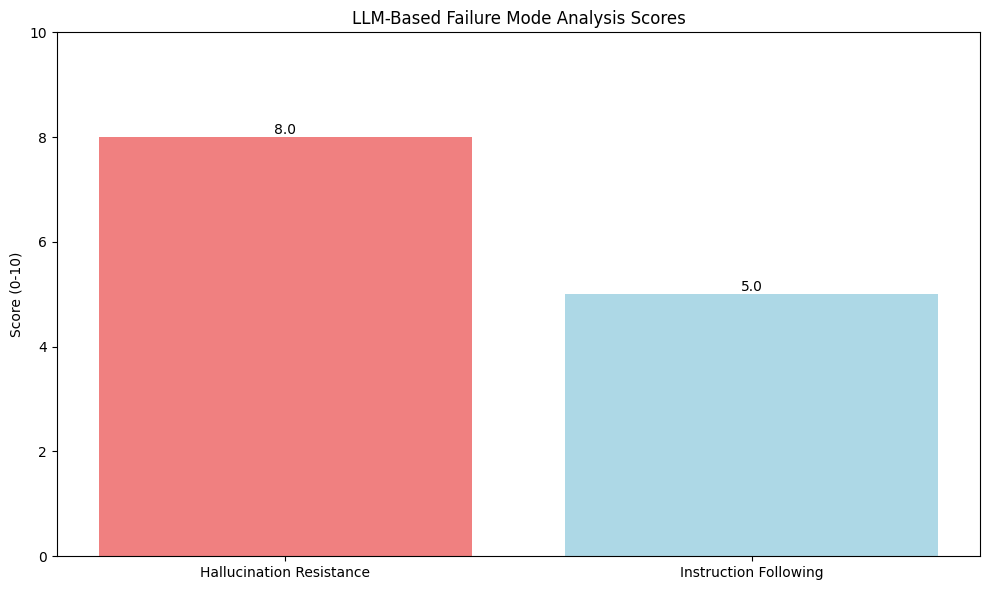

In [23]:
class LLMFailureModeAnalyzer(FailureModeAnalyzer):
    """Enhanced failure mode analyzer using LLM evaluation"""
    
    def __init__(self, llm_evaluator=None):
        super().__init__()
        self.llm_evaluator = llm_evaluator or LLMEvaluator()
    
    def analyze_hallucination_llm(self, agent, test_cases):
        """Analyze hallucination using LLM evaluation"""
        results = []
        
        for test_case in test_cases:
            response = agent.process_input(test_case)
            evaluation = self.llm_evaluator.detect_hallucination(test_case, response)
            
            results.append({
                "test_case": test_case,
                "response": response,
                "hallucination_score": evaluation["score"],
                "analysis": evaluation
            })
        
        return results
    
    def analyze_instruction_following_llm(self, agent, test_cases):
        """Analyze instruction following using LLM evaluation"""
        results = []
        
        for test_case in test_cases:
            response = agent.process_input(test_case)
            evaluation = self.llm_evaluator.evaluate_instruction_following(test_case, response)
            
            results.append({
                "test_case": test_case,
                "response": response,
                "instruction_following_score": evaluation["score"],
                "analysis": evaluation
            })
        
        return results
    
    def comprehensive_failure_analysis(self, agent):
        """Run comprehensive LLM-based failure mode analysis"""
        results = {}
        
        # Analyze hallucination
        hallucination_results = self.analyze_hallucination_llm(
            agent, 
            self.failure_modes["hallucination"]["test_cases"]
        )
        
        # Analyze instruction misalignment
        instruction_results = self.analyze_instruction_following_llm(
            agent,
            self.failure_modes["instruction_misalignment"]["test_cases"]
        )
        
        results["hallucination"] = {
            "average_score": sum(r["hallucination_score"] for r in hallucination_results) / len(hallucination_results),
            "results": hallucination_results
        }
        
        results["instruction_following"] = {
            "average_score": sum(r["instruction_following_score"] for r in instruction_results) / len(instruction_results),
            "results": instruction_results
        }
        
        return results

# Demonstrate LLM-based failure mode analysis
llm_failure_analyzer = LLMFailureModeAnalyzer()
failure_analysis = llm_failure_analyzer.comprehensive_failure_analysis(simple_agent)

print("LLM-Based Failure Mode Analysis:")
print("=" * 35)

# Display hallucination analysis
print("\n1. Hallucination Analysis:")
print(f"Average Hallucination Resistance Score: {failure_analysis['hallucination']['average_score']:.1f}/10")
print("(Higher score = better resistance to hallucination)")

for result in failure_analysis['hallucination']['results']:
    print(f"\nTest: {result['test_case']}")
    print(f"Response: {result['response']}")
    print(f"Hallucination Score: {result['hallucination_score']}/10")
    print(f"Analysis: {result['analysis']['reasoning']}")

# Display instruction following analysis
print("\n2. Instruction Following Analysis:")
print(f"Average Instruction Following Score: {failure_analysis['instruction_following']['average_score']:.1f}/10")

for result in failure_analysis['instruction_following']['results']:
    print(f"\nTest: {result['test_case']}")
    print(f"Response: {result['response']}")
    print(f"Instruction Following Score: {result['instruction_following_score']}/10")
    print(f"Analysis: {result['analysis']['reasoning']}")

# Create visualization of failure mode scores
failure_scores = {
    'Hallucination Resistance': failure_analysis['hallucination']['average_score'],
    'Instruction Following': failure_analysis['instruction_following']['average_score']
}

plt.figure(figsize=(10, 6))
bars = plt.bar(failure_scores.keys(), failure_scores.values(), color=['lightcoral', 'lightblue'])
plt.ylim(0, 10)
plt.ylabel('Score (0-10)')
plt.title('LLM-Based Failure Mode Analysis Scores')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

### Key Benefits and Implementation Notes

**Key Benefits of LLM-Based Evaluation:**

1. **Automated Subjective Assessment**: Provides consistent evaluation of qualitative dimensions like coherence and helpfulness
2. **Detailed Feedback**: Offers specific reasoning, strengths, weaknesses, and improvement suggestions
3. **Scalability**: Can evaluate large numbers of responses without human intervention
4. **Consistency**: Reduces variability in subjective evaluations across different human evaluators
5. **Integration**: Seamlessly integrates with existing quantitative evaluation frameworks

**Implementation Considerations:**

1. **API Integration**: Replace mock responses with actual OpenAI API calls by adding your API key
2. **Cost Management**: Monitor API usage costs, especially for large-scale evaluations
3. **Prompt Engineering**: Fine-tune evaluation prompts for your specific use case
4. **Validation**: Periodically validate LLM evaluations against human judgments
5. **Bias Awareness**: Be aware of potential biases in the evaluating LLM

**Usage Example for Real Implementation:**
```python
# Set your OpenAI API key
os.environ["OPENAI_API_KEY"] = "your-api-key-here"

# Initialize with real LLM evaluation
real_llm_evaluator = LLMEvaluator(model="gpt-4")
enhanced_evaluator = EnhancedAgentEvaluator(real_llm_evaluator)

# Run full evaluation
results = enhanced_evaluator.evaluate_agent_enhanced(your_agent, test_suite)
```